In [1]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd

import datasets
import torch
from torch.optim import AdamW

from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification 
from transformers import TrainingArguments,Trainer 
from transformers import EarlyStoppingCallback
from transformers.optimization import get_scheduler

# 数据准备

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("haoshaoyang/waimai-10k")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/haoshaoyang/waimai-10k/versions/1


In [3]:
df = pd.read_csv(os.path.join(path, "waimai_10k.csv"))
ds = datasets.Dataset.from_pandas(df)
ds = ds.shuffle(42) 
ds = ds.rename_columns({"review":"text","label":"labels"})

In [4]:
#模型下载
from modelscope import snapshot_download
model_dir = snapshot_download('tiansz/bert-base-chinese')

print("Path to model files:", model_dir)

Path to model files: /root/.cache/modelscope/hub/models/tiansz/bert-base-chinese


In [5]:
tokenizer = AutoTokenizer.from_pretrained("/root/.cache/modelscope/hub/models/tiansz/bert-base-chinese")

ds_encoded = ds.map(lambda example:tokenizer(example["text"]),
                    remove_columns = ["text"],
                    batched=True)

#train,val,test split
ds_train_val,ds_test = ds_encoded.train_test_split(test_size=0.2).values()
ds_train,ds_val = ds_train_val.train_test_split(test_size=0.2).values() 

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

dl_train = torch.utils.data.DataLoader(ds_train, batch_size=16, collate_fn = data_collator)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=16,  collate_fn = data_collator)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=16,  collate_fn = data_collator)

for batch in dl_train:
    break
print({k: v.shape for k, v in batch.items()})

Map:   0%|          | 0/11987 [00:00<?, ? examples/s]

{'labels': torch.Size([16]), 'input_ids': torch.Size([16, 101]), 'token_type_ids': torch.Size([16, 101]), 'attention_mask': torch.Size([16, 101])}


# 模型定义

In [6]:
model = AutoModelForSequenceClassification.from_pretrained(
    '/root/.cache/modelscope/hub/models/tiansz/bert-base-chinese', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /root/.cache/modelscope/hub/models/tiansz/bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
from merlin.tools.transformers import VLogCallback

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    preds = np.argmax(logits, axis=-1)
    accuracy = np.sum(preds==labels)/len(labels)
    precision = np.sum((preds==1)&(labels==1))/np.sum(preds==1)
    recall = np.sum((preds==1)&(labels==1))/np.sum(labels==1)
    f1  = 2*recall*precision/(recall+precision)
    return {"accuracy":accuracy,"precision":precision,"recall":recall,'f1':f1}

training_args = TrainingArguments(
    output_dir = "bert_waimai",
    num_train_epochs = 3,
    logging_steps = 20,
    gradient_accumulation_steps = 10,
    eval_strategy="steps", #epoch
    
    metric_for_best_model='eval_f1',
    greater_is_better=True,
    
    report_to='none',
    load_best_model_at_end=True
)

callbacks = [EarlyStoppingCallback(early_stopping_patience=10),
             VLogCallback()] #监控指标同 metric_for_best_model

# 模型训练

/tmp/ipykernel_2921/1835983306.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


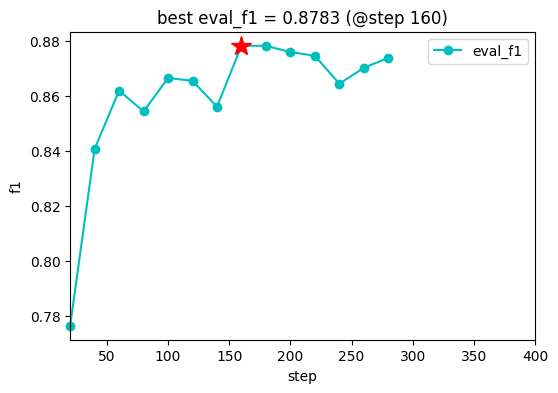

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,0.417700,0.330967,0.866006,0.899194,0.683002,0.776327
40,0.296000,0.264275,0.900417,0.923077,0.771822,0.840701
60,0.290600,0.248782,0.909802,0.900000,0.826953,0.861931
80,0.254400,0.254578,0.907195,0.917399,0.799387,0.854337
100,0.224600,0.253373,0.906674,0.844477,0.889740,0.866518
120,0.185300,0.253745,0.906674,0.849558,0.882083,0.865515
140,0.190200,0.265828,0.901981,0.856049,0.856049,0.856049
160,0.191100,0.236283,0.917623,0.883721,0.872894,0.878274
180,0.207500,0.246776,0.919187,0.901613,0.856049,0.878240
200,0.155900,0.273144,0.917623,0.898551,0.854518,0.875981


TrainOutput(global_step=288, training_loss=0.20468031325274044, metrics={'train_runtime': 99.6726, 'train_samples_per_second': 230.886, 'train_steps_per_second': 2.889, 'total_flos': 815211577263240.0, 'train_loss': 0.20468031325274044, 'epoch': 3.0})

In [11]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    compute_metrics=compute_metrics,
    callbacks = callbacks,
    data_collator=data_collator,
    tokenizer=tokenizer,
)
trainer.train() 

# 评估模型

In [12]:
trainer.evaluate(ds_val)

{'eval_loss': 0.27680665254592896,
 'eval_accuracy': 0.9139728884254432,
 'eval_precision': 0.8765432098765432,
 'eval_recall': 0.8698315467075038,
 'eval_f1': 0.8731744811683321,
 'eval_runtime': 1.7639,
 'eval_samples_per_second': 1087.392,
 'eval_steps_per_second': 136.066,
 'epoch': 3.0}

# 使用模型

In [13]:
from transformers import pipeline

model.config.id2label = {0:"差评",1:"好评"}
classifier = pipeline(task="text-classification",tokenizer = tokenizer,model=model.cpu())
classifier("挺好吃的哦")

Device set to use cuda:0


[{'label': '好评', 'score': 0.965003252029419}]

# 模型保存

In [14]:
model.save_pretrained("waimai_10k_bert")
tokenizer.save_pretrained("waimai_10k_bert")

classifier = pipeline("text-classification",model="waimai_10k_bert")
classifier(["味道还不错，下次再来","我去，吃了我吐了三天"])

Device set to use cuda:0


[{'label': '好评', 'score': 0.9708375334739685},
 {'label': '差评', 'score': 0.9897869825363159}]